In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd

import discretize 
from simpeg import maps
from simpeg.electromagnetics import time_domain as tdem

In [2]:
vtem_df = pd.read_csv("../geoscience-bc/5-GEOPHYSICS/OriginalData/EM_V-TEM_QUEST_GBCReport2008-4/Data/7042-MtMill.csv")
orig_waveform = np.loadtxt("../geoscience-bc/5-GEOPHYSICS/OriginalData/EM_V-TEM_QUEST_GBCReport2008-4/Data/7042_106_wform.xyz", skiprows=7)

In [3]:
waveform = np.loadtxt("../milligan/3D_INV(2012)/VTEM_milligan_TC6_TC20_3.wf")
# waveform = np.loadtxt("../dyang/Milligan_VTEM/INV_3D/Real_VTEM_3D.wf", usecols=[0, 1])
# waveform_amplitude = np.loadtxt("../dyang/Milligan_VTEM/INV_3D/Real_VTEM_3D.wf", usecols=1)

In [10]:
np.r_[
    4.6340000e-003,
    4.6810000e-003,
    4.7390000e-003,
    4.8060000e-003,
    4.8840000e-003,
    4.9730000e-003,
    5.0820000e-003,
    5.2180000e-003,
    5.3740000e-003,
    5.5510000e-003,
    5.7700000e-003,
    6.0410000e-003,
    6.3530000e-003,
    6.7070000e-003,
    7.1450000e-003,
] 

array([0.004634, 0.004681, 0.004739, 0.004806, 0.004884, 0.004973,
       0.005082, 0.005218, 0.005374, 0.005551, 0.00577 , 0.006041,
       0.006353, 0.006707, 0.007145])

In [32]:
1/30

0.03333333333333333

In [6]:
rx_times = pd.read_csv("./rx-times.csv")

In [44]:
centers = np.exp((np.log(rx_times["end"]) + np.log(rx_times["start"])) / 2)

In [21]:
len(tc)

19

In [45]:
tc - (centers*1e-6)[:19]

0     0.004411
1     0.004412
2     0.004416
3     0.004421
4     0.004426
5     0.004436
6     0.004447
7     0.004457
8     0.004468
9     0.004479
10    0.004497
11    0.004523
12    0.004545
13    0.004566
14    0.004603
15    0.004654
16    0.004699
17    0.004742
18    0.004816
dtype: float64

In [34]:
tc-4.5e-3

array([1.100e-05, 3.200e-05, 5.800e-05, 8.900e-05, 1.250e-04, 1.720e-04,
       2.300e-04, 2.970e-04, 3.750e-04, 4.640e-04, 5.730e-04, 7.090e-04,
       8.650e-04, 1.042e-03, 1.261e-03, 1.532e-03, 1.844e-03, 2.198e-03,
       2.636e-03])

In [42]:
test = tc - (rx_times["time gate"] * 1e-6)[:19]

In [43]:
test

0     0.004412
1     0.004412
2     0.004417
3     0.004422
4     0.004427
5     0.004438
6     0.004449
7     0.004458
8     0.004469
9     0.004480
10    0.004500
11    0.004527
12    0.004547
13    0.004568
14    0.004610
15    0.004662
16    0.004703
17    0.004745
18    0.004829
Name: time gate, dtype: float64

In [66]:
len(test)

19

Text(0.5, 0, 'time (s)')

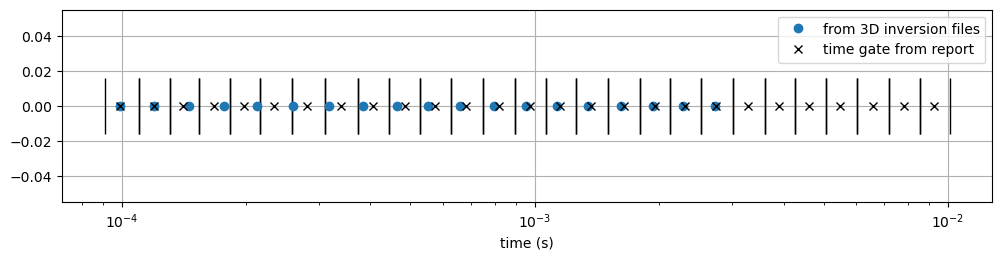

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(12, 2.5))
ax.semilogx(rx_times["start"]*1e-6, np.zeros(27), "|k", ms=40)
ax.semilogx(rx_times["end"]*1e-6, np.zeros(27), "|k", ms=40)

# ax.semilogx(centers*1e-6, np.zeros_like(centers), "s")
# ax.semilogx(rx_times["time gate"]*1e-6, np.zeros_like(rx_times["time gate"]), "s")
ax.semilogx(tc-4.412e-3, np.zeros_like(tc), "o", label="from 3D inversion files")
ax.semilogx(rx_times["time gate"]*1e-6, np.zeros(27), "kx", label="time gate from report")

ax.legend()
ax.grid(True)
ax.set_xlabel("time (s)")

In [71]:
wave_times = np.linspace(0, 1, len(waveform))*1e-5

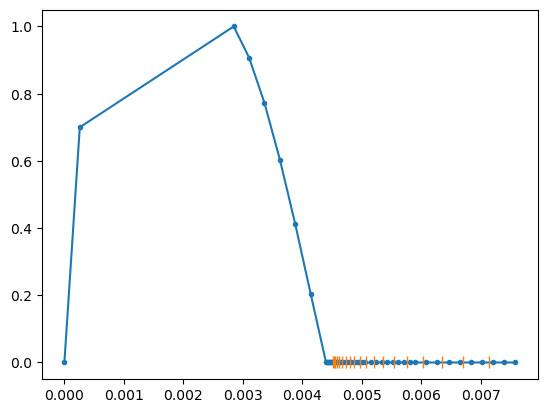

In [77]:
fig, ax = plt.subplots(1,1)
ax.plot(waveform[:, 0], waveform[:, 1], ".-")
# ax.plot(rx_times["time gate"]*1e-6, np.zeros(27), "|", ms=8)
ax.plot(tc, np.zeros_like(tc), "|", ms=8)


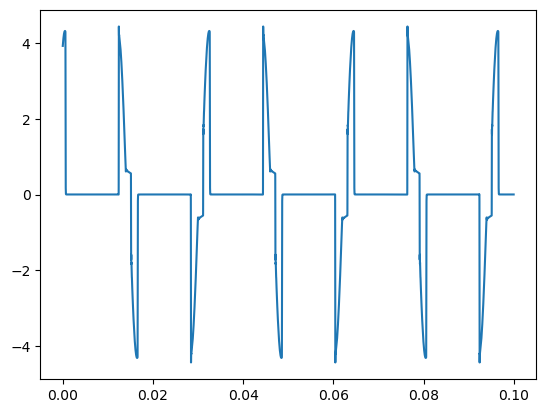

In [95]:
t_orig_waveform = np.arange(0, len(orig_waveform))*10e-6
fig, ax = plt.subplots(1, 1)
ax.plot(t_orig_waveform,orig_waveform)
# ax.set_xlim(0.047, 0.047+0.008)
